In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [3]:
from tensorflow.keras.layers import Dense,Flatten,GlobalAveragePooling2D,Dropout,BatchNormalization
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler,ReduceLROnPlateau,ModelCheckpoint,EarlyStopping

In [4]:
pre_trained_model = InceptionV3(input_shape = (128, 128, 3), 
                                include_top = False, 
                                weights = "imagenet")
for layer in pre_trained_model.layers:
    layer.trainable = False

87924736/87910968 [==============================] - 1s 0us/step


In [5]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 6, 6, 768)


In [6]:
fcHead = GlobalAveragePooling2D()(last_output)
fcHead = Dense(units=1024,
                        activation='relu')(fcHead)

fcHead = Dropout(0.5)(fcHead)

fcHead = BatchNormalization()(fcHead)
fcHead = Dense(3,activation='softmax')(fcHead)

model = Model(inputs = pre_trained_model.input, outputs = fcHead)

In [7]:
training_path = "/content/gdrive/MyDrive/Colab Notebooks/dataset/rps/rps-train-set"
validation_path = "/content/gdrive/MyDrive/Colab Notebooks/dataset/rps/rps-validation-set"
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 90, # auto rotate image from 0-180
                                   width_shift_range = 0.2, # crop 
                                   height_shift_range = 0.2,
                                   shear_range = 0.3, # rotate in axis-x
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

train_generator = train_datagen.flow_from_directory(training_path,
                                                    batch_size = 32,
                                                    class_mode = 'categorical', 
                                                    target_size = (128, 128))     

val_datagen = ImageDataGenerator(rescale = 1./255.)
val_generator = val_datagen.flow_from_directory(validation_path,
                                                batch_size = 32,
                                                class_mode = 'categorical', 
                                                target_size = (128, 128))   

Found 2520 images belonging to 3 classes.
Found 372 images belonging to 3 classes.


In [8]:
filepath="weights-best-rps.h5"
cp = ModelCheckpoint(filepath,monitor='loss', mode='min',save_best_only=True)
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=3)
my_callbacks = [cp,es]
model.compile(optimizer=RMSprop(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
history = model.fit(train_generator, epochs=15,
                    steps_per_epoch=20, 
                    validation_data = val_generator, 
                    verbose = 1, validation_steps=3,
                    callbacks=my_callbacks)

Epoch 1/15
20/20 [==============================] - 199s 8s/step - loss: 0.3561 - accuracy: 0.8703 - val_loss: 0.6370 - val_accuracy: 0.7917
Epoch 2/15
20/20 [==============================] - 127s 6s/step - loss: 0.1400 - accuracy: 0.9531 - val_loss: 0.5346 - val_accuracy: 0.8750
Epoch 3/15
20/20 [==============================] - 103s 5s/step - loss: 0.1302 - accuracy: 0.9469 - val_loss: 0.4839 - val_accuracy: 0.8854
Epoch 4/15
20/20 [==============================] - 59s 3s/step - loss: 0.1082 - accuracy: 0.9625 - val_loss: 0.4753 - val_accuracy: 0.8854
Epoch 5/15
20/20 [==============================] - 51s 3s/step - loss: 0.1313 - accuracy: 0.9500 - val_loss: 0.3296 - val_accuracy: 0.9375
Epoch 6/15
20/20 [==============================] - 36s 2s/step - loss: 0.1052 - accuracy: 0.9699 - val_loss: 0.3307 - val_accuracy: 0.9167
Epoch 7/15
20/20 [==============================] - 41s 2s/step - loss: 0.0655 - accuracy: 0.9797 - val_loss: 0.2554 - val_accuracy: 0.9792
Epoch 8/15
20/20 

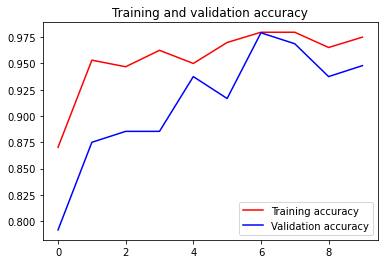

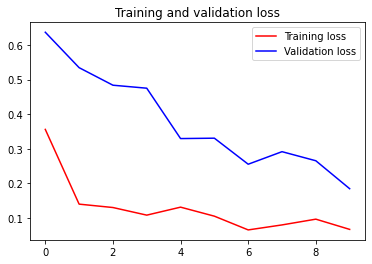

<Figure size 432x288 with 0 Axes>

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

plt.show()

In [28]:
import tensorflow as tf
def predict_image(image_upload, model = model):
  im = image_upload
  im_array = np.asarray(im)
  im_array = im_array*(1/225)
  im_input = tf.reshape(im_array, shape = [1, 128, 128, 3])

  predict_proba = sorted(model.predict(im_input)[0])[2]
  predict_class = np.argmax(model.predict(im_input))

  if predict_class == 0:
      predict_label = 'Paper'
  elif predict_class == 1:
      predict_label = 'Rock'
  else:
      predict_label = 'Scissor'

  print('\n')
  plt.show()
  print("\nImage prediction result: ", predict_label)
  print("Probability: ", round(predict_proba*100,2), "%")
  print('\n')

Saving rock4.png to rock4.png




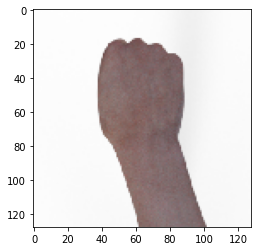


Image prediction result:  Rock
Probability:  99.72 %




In [30]:

uploaded = files.upload()

for fn in uploaded.keys():
  path = fn
  img = image.load_img(path, target_size=(128,128))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  img = np.vstack([x])

predict_image(img)

In [13]:
import cv2
def _image_read(image_path):
  image = cv2.imread(image_path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(128,128))
  return image

In [22]:
img = _image_read('/content/gdrive/MyDrive/Colab Notebooks/dataset/rps/rps-train-set/scissors/scissors01-000.png')
x = np.expand_dims(img,axis=0)
x.shape

(1, 128, 128, 3)

In [23]:
one = model.predict(x)
print(np.argmax(one))

1


In [12]:
from google.colab import files
from keras.preprocessing import image

uploaded=files.upload()

for fn in uploaded.keys():
  # predicting images
  path='/content/' + fn
  img=image.load_img(path, target_size=(128, 128))
  
  x=image.img_to_array(img)
  x=np.expand_dims(x, axis=0)
  images = np.vstack([x])
  print(images.shape)
  classes = model.predict(images)
  print(classes)

Saving paper1.png to paper1 (1).png
(1, 128, 128, 3)
[[0. 1. 0.]]
